In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import numpy as np
import pandas as pd
import json
import requests
import re
import os
from datetime import datetime as dt
from pandas.io.json import json_normalize
import matplotlib.pylab as plt
import seaborn as sns
import shapefile
from sklearn import preprocessing
%matplotlib inline

df_train = pd.read_csv('cs5228-2020-semester-2-final-project/train.csv')
df_train

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431727,2005-03,woodlands,4 room,537,Woodlands Drive 16,01 to 03,101.0,model a,uncategorized,2000,1.429658,103.792583,0.0,woodlands south,woodlands,north region,238500.0
431728,2016-04,sengkang,4 room,410A,fernvale road,13 to 15,95.0,premium apartment,uncategorized,2012,1.390053,103.875941,0.0,fernvale,sengkang,north-east region,376200.0
431729,2011-01,tampines,3-room,829,tampines street 81,01 to 03,67.0,new generation,uncategorized,1986,1.349224,103.934913,0.0,tampines west,tampines,east region,255600.0
431730,2013-05,sengkang,5-room,233,compassvale walk,16 to 18,123.0,improved,uncategorized,1999,1.389941,103.900721,0.0,sengkang town centre,sengkang,north-east region,508500.0


In [8]:
df_train.isnull().values.any()
df_train.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region', 'resale_price'],
      dtype='object')

In [9]:
df_init = df_train.copy()
df_init['remaining_lease'] = df_init['lease_commence_date'].astype(int) - 1918
df_init

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price,remaining_lease
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0,71
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0,85
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0,86
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0,62
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431727,2005-03,woodlands,4 room,537,Woodlands Drive 16,01 to 03,101.0,model a,uncategorized,2000,1.429658,103.792583,0.0,woodlands south,woodlands,north region,238500.0,82
431728,2016-04,sengkang,4 room,410A,fernvale road,13 to 15,95.0,premium apartment,uncategorized,2012,1.390053,103.875941,0.0,fernvale,sengkang,north-east region,376200.0,94
431729,2011-01,tampines,3-room,829,tampines street 81,01 to 03,67.0,new generation,uncategorized,1986,1.349224,103.934913,0.0,tampines west,tampines,east region,255600.0,68
431730,2013-05,sengkang,5-room,233,compassvale walk,16 to 18,123.0,improved,uncategorized,1999,1.389941,103.900721,0.0,sengkang town centre,sengkang,north-east region,508500.0,81


In [10]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                431732 non-null  object 
 1   town                 431732 non-null  object 
 2   flat_type            431732 non-null  object 
 3   block                431732 non-null  object 
 4   street_name          431732 non-null  object 
 5   storey_range         431732 non-null  object 
 6   floor_area_sqm       431732 non-null  float64
 7   flat_model           431732 non-null  object 
 8   eco_category         431732 non-null  object 
 9   lease_commence_date  431732 non-null  int64  
 10  latitude             431732 non-null  float64
 11  longitude            431732 non-null  float64
 12  elevation            431732 non-null  float64
 13  subzone              431732 non-null  object 
 14  planning_area        431732 non-null  object 
 15  region           

In [11]:
df_init.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,resale_price,remaining_lease
count,431732.000000,431732.000000,431732.000000,431732.000000,431732.0,4.317320e+05,431732.000000
mean,96.970064,1989.421004,1.364939,103.836492,0.0,3.018196e+05,71.421004
std,25.190664,10.254055,0.042829,0.073527,0.0,1.298623e+05,10.254055
min,31.000000,1966.000000,1.270380,103.685228,0.0,2.970000e+04,48.000000
25%,74.000000,1983.000000,1.336154,103.772439,0.0,2.052000e+05,65.000000
50%,99.000000,1988.000000,1.358958,103.840160,0.0,2.839500e+05,70.000000
75%,114.000000,1997.000000,1.389004,103.895779,0.0,3.735000e+05,79.000000
max,280.000000,2019.000000,1.457071,103.987805,0.0,1.123200e+06,101.000000


In [50]:
print(df_init['street_name'].nunique())
print(df_init['town'].nunique()) #can drop
print(df_init['flat_type'].nunique())
print(df_init['flat_model'].nunique())
print(df_init['eco_category'].nunique()) #can drop
print(df_init['subzone'].nunique()) #can drop
print(df_init['planning_area'].nunique())
print(df_init['region'].nunique())
print(df_init['latitude'].nunique())

1103
26
12
20
1
155
32
5
9138


In [13]:
df_init['price_sqm'] = df_init['resale_price']/df_init['floor_area_sqm']
df_init

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price,remaining_lease,price_sqm
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0,71,1777.118644
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0,85,3657.272727
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0,86,3133.928571
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0,62,2256.716418
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0,67,4364.383562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431727,2005-03,woodlands,4 room,537,Woodlands Drive 16,01 to 03,101.0,model a,uncategorized,2000,1.429658,103.792583,0.0,woodlands south,woodlands,north region,238500.0,82,2361.386139
431728,2016-04,sengkang,4 room,410A,fernvale road,13 to 15,95.0,premium apartment,uncategorized,2012,1.390053,103.875941,0.0,fernvale,sengkang,north-east region,376200.0,94,3960.000000
431729,2011-01,tampines,3-room,829,tampines street 81,01 to 03,67.0,new generation,uncategorized,1986,1.349224,103.934913,0.0,tampines west,tampines,east region,255600.0,68,3814.925373
431730,2013-05,sengkang,5-room,233,compassvale walk,16 to 18,123.0,improved,uncategorized,1999,1.389941,103.900721,0.0,sengkang town centre,sengkang,north-east region,508500.0,81,4134.146341


In [14]:
df_init['street_name'] = df_init['street_name'].str.replace('UPP ', 'UPPER ', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace(' CTRL', ' CENTRAL', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace('JLN ', 'JALAN ', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace('BT ', 'BUKIT ', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace('LOR ', 'LORONG ', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace(' NTH', ' NORTH', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace('NTH BRIDGE', 'NORTH BRIDGE', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace('KG', 'KAMPONG', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace(' DR', ' DRIVE', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace('TG PAGAR', 'TANJONG PAGAR', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace("C'WEALTH", 'COMMONWEALTH', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace("WOODLANDS DRIVE 75", 'WOODLAND DRIVE 75', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace("TAMAN HO SWEE", 'JALAN BUKIT HO SWEE', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace("YUNG PING RD", '157 CORPORATION DRIVE', regex = True)
df_init['street_name'] = df_init['street_name'].str.replace("YUNG LOH RD", '157 CORPORATION DRIVE', regex = True)
address_set = df_init["street_name"].unique().tolist()
print(len(address_set))

1103


In [26]:
df_primary_schools = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-primary-schools.csv')
df_secondary_schools = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-secondary-schools.csv')
df_commerical = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-commerical-centres.csv')
df_hawker = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-gov-markets-hawker-centres.csv')
df_malls = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-shopping-malls.csv')
df_stations = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-train-stations.csv')
df_demographics = pd.read_csv('cs5228-2020-semester-2-final-project/auxiliary-data/sg-population-demographics.csv')

In [16]:
import geopy
import geopy.distance
df_init["lat_long"] = df_init[['latitude', 'longitude']].apply(geopy.Point, axis=1)
df_unique_point = df_init.groupby(['latitude', 'longitude']).size().reset_index(name='Freq')
df_unique_point["lat_long"] = df_unique_point[['latitude', 'longitude']].apply(geopy.Point, axis=1)
df_unique_point

,latitude,longitude,Freq,lat_long
0,1.270380,103.823236,58,"1 16m 13.3662s N, 103 49m 23.6495s E"
1,1.270919,103.822685,62,"1 16m 15.3074s N, 103 49m 21.6674s E"
2,1.271409,103.810888,144,"1 16m 17.0718s N, 103 48m 39.1951s E"
3,1.271463,103.825684,55,"1 16m 17.2652s N, 103 49m 32.4608s E"
4,1.271691,103.809852,18,"1 16m 18.0862s N, 103 48m 35.4681s E"
...,...,...,...,...
9133,1.456235,103.814292,21,"1 27m 22.4463s N, 103 48m 51.4519s E"
9134,1.456425,103.815858,93,"1 27m 23.1295s N, 103 48m 57.087s E"
9135,1.456474,103.817181,59,"1 27m 23.3075s N, 103 49m 1.85289s E"
9136,1.456546,103.816764,60,"1 27m 23.5656s N, 103 49m 0.349981s E"


In [17]:
def calculate_nearest(venue_name, venue_df):
    df_unique_point["lat_long"] = df_unique_point[['latitude', 'longitude']].apply(geopy.Point, axis=1)
    venue_distance = pd.DataFrame(df_unique_point['lat_long'])
    venue_df["lat_long"] = venue_df[['lat', 'lng']].apply(geopy.Point, axis=1)
    venue_list = list(venue_df.T.iloc[-1,:])
    for x in venue_list:
        venue_distance[tuple(x)] = df_unique_point['lat_long'].apply(lambda y: geopy.distance.geodesic(y,x).km)
    venue_distance["lat_long"] = venue_distance["lat_long"].apply(tuple)
    feature_name = str('distance_to_nearest_'+venue_name)
    venue_distance[feature_name] = venue_distance.iloc[:,1:].apply(lambda x: min(x), axis=1)
    venue_distance = venue_distance.iloc[:,[0,-1]]
    df_unique_point["lat_long"] = df_unique_point["lat_long"].apply(tuple)
    df_with_venues = pd.merge(df_unique_point, venue_distance, on='lat_long', how='left')
    return df_with_venues

In [31]:
df_primary_schools = df_primary_schools.dropna()
df_secondary_schools = df_secondary_schools.dropna()
df_commerical = df_commerical.dropna()
df_hawker = df_hawker.dropna()
df_malls = df_malls.dropna()
df_stations = df_stations.dropna()
df_demographics = df_demographics.dropna()

In [32]:
df_primary_schools = calculate_nearest('primary_sch',df_primary_schools)
df_secondary_schools = calculate_nearest('second_sch',df_secondary_schools)
df_commercial = calculate_nearest('commercial',df_commerical)
df_hawker = calculate_nearest('hawker',df_hawker)
df_malls = calculate_nearest('malls',df_malls)
df_stations = calculate_nearest('stations',df_stations)

In [44]:
df_init['lat_long'] =  df_init["lat_long"].apply(tuple)
df_merged_venue = pd.merge(df_init, df_stations, on='lat_long', how='left')
df_merged_venue = pd.merge(df_merged_venue, df_primary_schools, on='lat_long', how='left')
df_merged_venue = pd.merge(df_merged_venue, df_secondary_schools, on='lat_long', how='left')
df_merged_venue = pd.merge(df_merged_venue, df_commercial, on='lat_long', how='left')
df_merged_venue = pd.merge(df_merged_venue, df_hawker, on='lat_long', how='left')
df_merged_venue = pd.merge(df_merged_venue, df_malls, on='lat_long', how='left')
df_merged_venue

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,Freq_y,distance_to_nearest_commercial,latitude_y,longitude_y,Freq_x,distance_to_nearest_hawker,latitude,longitude,Freq_y,distance_to_nearest_malls
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,32,2.307216,1.369008,103.958697,32,0.944998,1.369008,103.958697,32,1.028772
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,36,1.455538,1.399007,103.906991,36,3.773975,1.399007,103.906991,36,0.812607
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,30,1.445009,1.388348,103.873815,30,1.797718,1.388348,103.873815,30,0.450920
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,90,2.386699,1.318493,103.766702,90,0.615444,1.318493,103.766702,90,0.454836
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,63,1.800060,1.348149,103.742658,63,0.760363,1.348149,103.742658,63,0.764628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431727,2005-03,woodlands,4 room,537,Woodlands Drive 16,01 to 03,101.0,model a,uncategorized,2000,...,72,1.036933,1.429658,103.792583,72,1.470056,1.429658,103.792583,72,1.014346
431728,2016-04,sengkang,4 room,410A,fernvale road,13 to 15,95.0,premium apartment,uncategorized,2012,...,25,1.609766,1.390053,103.875941,25,1.844287,1.390053,103.875941,25,0.190375
431729,2011-01,tampines,3-room,829,tampines street 81,01 to 03,67.0,new generation,uncategorized,1986,...,41,1.224333,1.349224,103.934913,41,0.723242,1.349224,103.934913,41,0.766860
431730,2013-05,sengkang,5-room,233,compassvale walk,16 to 18,123.0,improved,uncategorized,1999,...,37,1.616832,1.389941,103.900721,37,2.581630,1.389941,103.900721,37,0.682419


In [46]:
df_merged_venue.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'latitude_x', 'longitude_x', 'elevation', 'subzone', 'planning_area',
       'region', 'resale_price', 'remaining_lease', 'price_sqm', 'lat_long',
       'latitude_y', 'longitude_y', 'Freq_x', 'distance_to_nearest_stations',
       'latitude_x', 'longitude_x', 'Freq_y',
       'distance_to_nearest_primary_sch', 'latitude_y', 'longitude_y',
       'Freq_x', 'distance_to_nearest_second_sch', 'latitude_x', 'longitude_x',
       'Freq_y', 'distance_to_nearest_commercial', 'latitude_y', 'longitude_y',
       'Freq_x', 'distance_to_nearest_hawker', 'latitude', 'longitude',
       'Freq_y', 'distance_to_nearest_malls'],
      dtype='object')

In [78]:
df_merged_venue = df_merged_venue[['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'elevation', 'subzone', 'planning_area',
       'region', 'resale_price', 'remaining_lease', 'price_sqm', 
       'distance_to_nearest_stations',
       'distance_to_nearest_primary_sch', 
       'distance_to_nearest_second_sch', 
       'distance_to_nearest_commercial', 
       'distance_to_nearest_hawker',
       'distance_to_nearest_malls']]

In [70]:
print(df_merged_venue['flat_model'].nunique())
df_merged_venue['flat_model'] = df_merged_venue['flat_model'].str.replace('2-ROOM', '2-room') \
                                    .str.replace('MULTI GENERATION', 'Multi Generation') \
                                    .str.replace('PREMIUM APARTMENT', 'Premium Apartment') \
                                    .str.replace('Premium Apartment.', 'Premium Apartment') \
                                    .str.replace('Premium Apartment Loft', 'Premium Apartment') \
                                    .str.replace('NEW GENERATION', 'New Generation') \
                                    .str.replace('MODEL A', 'Model A') \
                                    .str.replace('Improved-MAISONETTE', 'Maisonette') \
                                    .str.replace('Model A-Maisonette', 'Maisonette') \
                                    .str.replace('Premium ApartmentLoft', 'Premium Apartment') \
                                    .str.replace('flat_type_MULTI-GENERATION', 'flat_type_MULTI GENERATION') \
                                    .str.replace('flat_model_PREMIUM Apartment', 'flat_model_Premium Apartment') \
                                    .str.replace('Model A-MAISONETTE', 'Maisonette') \
                                    .str.replace('APARTMENT', 'Apartment') \
                                    .str.replace('MAISONETTE', 'Maisonette') \
                                    .str.replace('IMPROVED', 'Improved') \
                                    .str.replace('SIMPLIFIED', 'Simplified') \
                                    .str.replace('MODEL A-MAISONETTE', 'Maisonette') \
                                    .str.replace('Improved-Maisonette', 'Maisonette') \
                                    .str.replace('Premium Maisonette', 'Maisonette') \
                                    .str.replace('ADJOINED FLAT', 'Adjoined flat') \
                                    .str.replace('TERRACE', 'Terrace') 

df_merged_venue['flat_model'].nunique()

20


<ipython-input-70-f4eee7148797>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_merged_venue['flat_model'] = df_merged_venue['flat_model'].str.replace('2-ROOM', '2-room') \
<ipython-input-70-f4eee7148797>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_venue['flat_model'] = df_merged_venue['flat_model'].str.replace('2-ROOM', '2-room') \


20

In [71]:
df_merged_venue['flat_type'].unique()
df_merged_venue['flat_type'] = df_merged_venue['flat_type'].str.replace('5-room', '5 room')\
                                                           .str.replace('4-room', '4 room')\
                                                           .str.replace('3-room', '3 room')\
                                                           .str.replace('2-room', '2 room')\
                                                           .str.replace('1-room', '1 room')
df_merged_venue['flat_type'].unique()

<ipython-input-71-cbac41c21ce3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_venue['flat_type'] = df_merged_venue['flat_type'].str.replace('5-room', '5 room')\


array(['4 room', '5 room', '3 room', 'executive', '2 room',
       'multi generation', '1 room'], dtype=object)

In [72]:
df_merged_venue['toilet_number'] = df_merged_venue['flat_type'].map({
    '1 room': 1,
    '2 room': 1,
    '3 room': 2,
    '4 room': 2,
    '5 room': 2,
    'executive': 2,
    'multi generation': 3
})

<ipython-input-72-4b55d68e0b7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_venue['toilet_number'] = df_merged_venue['flat_type'].map({


In [73]:
df_merged_venue['room_number'] = df_merged_venue['flat_type'].map({
    '1 room': 1,
    '2 room': 2,
    '3 room': 3,
    '4 room': 4,
    '5 room': 5,
    'executive': 3,
    'multi generation': 4
})

In [94]:
df_onehot = pd.get_dummies(df_merged_venue[['flat_type', 'flat_model', 'storey_range', 'planning_area', 'region']])
df_main_onehot = df_merged_venue.join(df_onehot)      
df_main_onehot.drop(['town','month', 'flat_type','flat_model', 'eco_category', 'subzone', 'planning_area',\
               'resale_price','block','lease_commence_date','subzone', 'region', 'elevation'], 
              axis = 1, inplace = True)
df_main_onehot

,street_name,storey_range,floor_area_sqm,remaining_lease,price_sqm,distance_to_nearest_stations,distance_to_nearest_primary_sch,distance_to_nearest_second_sch,distance_to_nearest_commercial,distance_to_nearest_hawker,...,planning_area_tampines,planning_area_tanglin,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun,region_central region,region_east region,region_north region,region_north-east region,region_west region
0,pasir ris drive 4,01 to 03,118.0,71,1777.118644,1.137651,0.343632,0.426132,2.307216,0.944998,...,0,0,0,0,0,0,1,0,0,0
1,punggol field,10 to 12,110.0,85,3657.272727,0.821397,0.160104,0.311598,1.455538,3.773975,...,0,0,0,0,0,0,0,0,1,0
2,fernvale lane,01 to 03,112.0,86,3133.928571,2.232095,0.183945,0.558057,1.445009,1.797718,...,0,0,0,0,0,0,0,0,1,0
3,clementi avenue 4,07 to 09,67.0,62,2256.716418,0.421346,0.303219,0.618757,2.386699,0.615444,...,0,0,0,0,0,0,0,0,0,1
4,bukit batok street 11,07 to 09,73.0,67,4364.383562,0.775005,0.233534,0.218129,1.800060,0.760363,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431727,Woodlands Drive 16,01 to 03,101.0,82,2361.386139,0.300402,0.210006,0.336660,1.036933,1.470056,...,0,0,0,1,0,0,0,1,0,0
431728,fernvale road,13 to 15,95.0,94,3960.000000,2.070084,0.192740,0.262617,1.609766,1.844287,...,0,0,0,0,0,0,0,0,1,0
431729,tampines street 81,01 to 03,67.0,68,3814.925373,0.567511,0.187832,0.250725,1.224333,0.723242,...,1,0,0,0,0,0,1,0,0,0
431730,compassvale walk,16 to 18,123.0,81,4134.146341,0.614204,0.159620,0.288516,1.616832,2.581630,...,0,0,0,0,0,0,0,0,1,0


In [95]:
df_main_onehot.columns.to_list()

['street_name',
 'storey_range',
 'floor_area_sqm',
 'remaining_lease',
 'price_sqm',
 'distance_to_nearest_stations',
 'distance_to_nearest_primary_sch',
 'distance_to_nearest_second_sch',
 'distance_to_nearest_commercial',
 'distance_to_nearest_hawker',
 'distance_to_nearest_malls',
 'flat_type_1 room',
 'flat_type_2 room',
 'flat_type_3 room',
 'flat_type_4 room',
 'flat_type_5 room',
 'flat_type_executive',
 'flat_type_multi generation',
 'flat_model_2 room',
 'flat_model_adjoined flat',
 'flat_model_apartment',
 'flat_model_dbss',
 'flat_model_improved',
 'flat_model_improved maisonette',
 'flat_model_maisonette',
 'flat_model_model a',
 'flat_model_model a maisonette',
 'flat_model_model a2',
 'flat_model_multi generation',
 'flat_model_new generation',
 'flat_model_premium apartment',
 'flat_model_premium apartment loft',
 'flat_model_premium maisonette',
 'flat_model_simplified',
 'flat_model_standard',
 'flat_model_terrace',
 'flat_model_type s1',
 'flat_model_type s2',
 'stor

In [96]:
df_main_onehot['storey_avg'] = df_main_onehot['storey_range'].apply(lambda x: int(x[-2:]))
   
df_main_onehot['storey < 10'] = df_main_onehot['storey_range_01 to 03']\
                        + df_main_onehot['storey_range_01 to 05']\
                        + df_main_onehot['storey_range_04 to 06']\
                        + df_main_onehot['storey_range_06 to 10']\
                        + df_main_onehot['storey_range_07 to 09']\
                
df_main_onehot['storey < 15'] = df_main_onehot['storey_range_10 to 12']\
                        + df_main_onehot['storey_range_11 to 15'] 
                                   
df_main_onehot['storey < 20'] = df_main_onehot['storey_range_16 to 18']\
                        + df_main_onehot['storey_range_16 to 20'] 
    
df_main_onehot['storey < 30'] = df_main_onehot['storey_range_19 to 21']\
                        + df_main_onehot['storey_range_21 to 25']\
                        + df_main_onehot['storey_range_22 to 24']\
                        + df_main_onehot['storey_range_06 to 10']\
                        + df_main_onehot['storey_range_25 to 27']\
                        + df_main_onehot['storey_range_26 to 30']\
                        + df_main_onehot['storey_range_28 to 30']
                        
df_main_onehot['story > 30'] = df_main_onehot['storey_range_31 to 33']\
                        + df_main_onehot['storey_range_31 to 35']\
                        + df_main_onehot['storey_range_34 to 36']\
                        + df_main_onehot['storey_range_36 to 40']\
                        + df_main_onehot['storey_range_37 to 39']\
                        + df_main_onehot['storey_range_40 to 42']\
                        + df_main_onehot['storey_range_43 to 45']\
                        + df_main_onehot['storey_range_46 to 48']\
                        + df_main_onehot['storey_range_49 to 51']
                        
df_main_onehot.drop(['storey_range_01 to 03',
                'storey_range_01 to 05',
                'storey_range_04 to 06',
                'storey_range_06 to 10',
                'storey_range_07 to 09',
                'storey_range_10 to 12',
                'storey_range_11 to 15',
                'storey_range_13 to 15',
                'storey_range_16 to 18',
                'storey_range_16 to 20',
                'storey_range_19 to 21',
                'storey_range_21 to 25',
                'storey_range_22 to 24',
                'storey_range_25 to 27',
                'storey_range_26 to 30',
                'storey_range_28 to 30',
                'storey_range_31 to 33',
                'storey_range_31 to 35',
                'storey_range_34 to 36',
                'storey_range_36 to 40',
                'storey_range_37 to 39',
                'storey_range_40 to 42',
                'storey_range_43 to 45',
                'storey_range_46 to 48',
                'storey_range_49 to 51','storey_range'], 
                axis = 1, inplace = True)

In [97]:
df_main_onehot.columns

Index(['street_name', 'floor_area_sqm', 'remaining_lease', 'price_sqm',
       'distance_to_nearest_stations', 'distance_to_nearest_primary_sch',
       'distance_to_nearest_second_sch', 'distance_to_nearest_commercial',
       'distance_to_nearest_hawker', 'distance_to_nearest_malls',
       'flat_type_1 room', 'flat_type_2 room', 'flat_type_3 room',
       'flat_type_4 room', 'flat_type_5 room', 'flat_type_executive',
       'flat_type_multi generation', 'flat_model_2 room',
       'flat_model_adjoined flat', 'flat_model_apartment', 'flat_model_dbss',
       'flat_model_improved', 'flat_model_improved maisonette',
       'flat_model_maisonette', 'flat_model_model a',
       'flat_model_model a maisonette', 'flat_model_model a2',
       'flat_model_multi generation', 'flat_model_new generation',
       'flat_model_premium apartment', 'flat_model_premium apartment loft',
       'flat_model_premium maisonette', 'flat_model_simplified',
       'flat_model_standard', 'flat_model_terrace',

Text(0.5, 1.0, 'Correlation Plot')

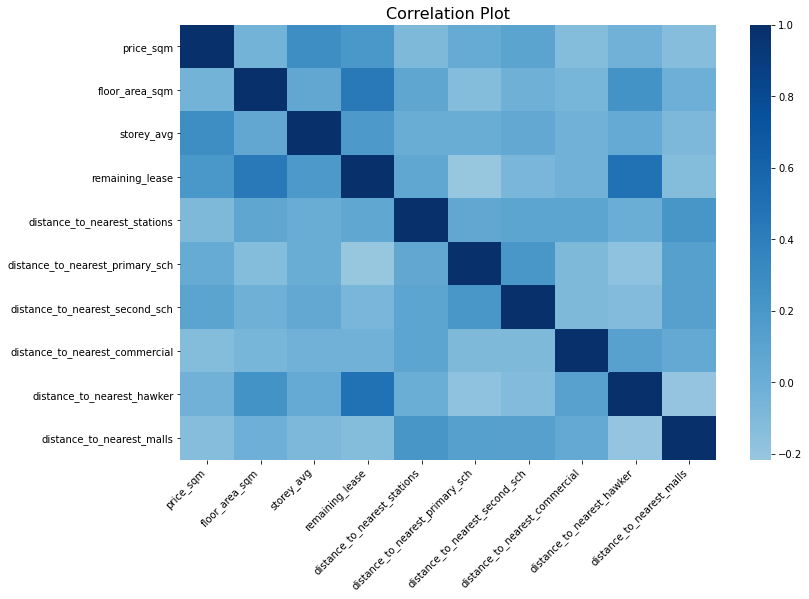

In [100]:
df_corr1 = df_main_onehot[['price_sqm', 'floor_area_sqm','storey_avg', 'remaining_lease',
       'distance_to_nearest_stations', 'distance_to_nearest_primary_sch',
       'distance_to_nearest_second_sch', 'distance_to_nearest_commercial',
       'distance_to_nearest_hawker', 'distance_to_nearest_malls']].copy()

corr1 = df_corr1.corr()

plt.figure(figsize=(12,8))
ax = sns.heatmap(corr1,
                 center = 0,
                 cmap='Blues')


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

ax.set_title("Correlation Plot", size =16)